In [1]:
import pandas as pd
import sqlalchemy as sa

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

import numpy as np

import json

C:\Users\christopher.sampson\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [7]:
# Inter arrival time

with open("data/iats.json", 'r') as fin:
    iat_dict = json.load(fin)

iat_dict = {k:(np.array(v[0]), np.array(v[1])) for k,v in iat_dict.items()}

In [9]:
# Wait list

tno_wait_list_df = pd.read_csv("data/wait_list.csv")

In [13]:
# Proecdure durations

with open("data/surgery_durations.json", 'r') as fin:
    theatre_dur_dict = json.load(fin)

theatre_dur_dict = {k:(np.array(v[0]), np.array(v[1])) for k,v in theatre_dur_dict.items()}

In [19]:
# Remaining LoS

with open("data/remaining_los.json", 'r') as fin:
    remaining_los = json.load(fin)

remaining_los = (np.array(remaining_los[0]), np.array(remaining_los[1]))

In [20]:
# LoS

with open("data/los.json", 'r') as fin:
    los_dict = json.load(fin)

los_dict = {k:(np.array(v[0]), np.array(v[1])) for k,v in los_dict.items()}

In [60]:
# Theatre slots

def create_schedule():
    theatre_schedule_df = pd.read_csv("data/theatre_schedule.csv")
    theatre_schedule_df["patients"] = [[] for _ in range(len(theatre_schedule_df))]

    return theatre_schedule_df

In [26]:
# Initial occupancy

init_occupancy_df = pd.read_csv("data/initial_occupancy.csv")

In [24]:
# Occupancy

occupancy_df = pd.read_csv("data/occupancy.csv")

In [29]:
# Initial emergency patients

emerg_wait_list = pd.DataFrame(np.random.randint(0, 48, size=52), columns=["hours_waited"])
emerg_wait_list = emerg_wait_list.sort_values(by="hours_waited", ascending=False)

In [64]:
# Setting up the experiement

import itertools
from surgical_sim import Patient
from sim_tools.distributions import GroupedContinuousEmpirical, DiscreteEmpirical


SEED = 42

EMERGENCY_MEAN_IAT = 10
EMERGENCY_SURGICAL_DURATION = 3
EMERGENCY_MEAN_RECOVERY_TIME = 60

ELECTIVE_MEAN_IAT = 16
ELECTIVE_SURGICAL_DURATION = 2
ELECTIVE_MEAN_RECOVERY_TIME = 48

RUN_LENGTH = 480
NUM_BEDS = 100
NUM_CC_BEDS = 16

DAILY = 24
WEEKLY = 7 * DAILY

INITIAL_NUMBER_OF_ELECTIVE = 3
INITIAL_NUMBER_OF_EMERGENCY = 1

MAX_EMERGENCY_WAIT = 48


class Experiment:
    def __init__(
        self,
        iat_dict,
        theatre_dur_dict,
        los_dict,
        remaining_los,
        seed=SEED,
        initial_number_of_elective=INITIAL_NUMBER_OF_ELECTIVE,
        initial_number_of_emergency=INITIAL_NUMBER_OF_EMERGENCY,
        max_emergency_wait=MAX_EMERGENCY_WAIT,
    ):
        self.patients = []

        self.initial_number_of_elective = initial_number_of_elective
        self.initial_number_of_emergency = initial_number_of_emergency

        seeds = np.random.SeedSequence(seed).spawn(10)

        self.emergency_arrival_dist = GroupedContinuousEmpirical(
            lower_bounds = iat_dict["EMERG"][1][:-1],
            upper_bounds = iat_dict["EMERG"][1][1:],
            freq = iat_dict["EMERG"][0],
            random_seed = seeds[0]
        )

        self.elective_arrival_dist = GroupedContinuousEmpirical(
            lower_bounds = iat_dict["ELECT"][1][:-1],
            upper_bounds = iat_dict["ELECT"][1][1:],
            freq = iat_dict["ELECT"][0],
            random_seed = seeds[1]
        )

        self.dcase_arrival_dist = GroupedContinuousEmpirical(
            lower_bounds = iat_dict["DCASE"][1][:-1],
            upper_bounds = iat_dict["DCASE"][1][1:],
            freq = iat_dict["DCASE"][0],
            random_seed = seeds[2]
        )

        mask = np.where(theatre_dur_dict["EMERG"][0] > 0)
        self.emergency_surgical_duration_dist = DiscreteEmpirical(
            ((theatre_dur_dict["EMERG"][1][:-1] + theatre_dur_dict["EMERG"][1][1:]) /2)[mask],
            theatre_dur_dict["EMERG"][0][mask],
            random_seed = seeds[3]
        )

        mask = np.where(theatre_dur_dict["ELECT"][0] > 0)
        self.elective_surgical_duration_dist = DiscreteEmpirical(
            ((theatre_dur_dict["ELECT"][1][:-1] + theatre_dur_dict["ELECT"][1][1:]) /2)[mask],
            theatre_dur_dict["ELECT"][0][mask],
            random_seed = seeds[4]
        )

        mask = np.where(theatre_dur_dict["DCASE"][0] > 0)
        self.dcase_surgical_duration_dist = DiscreteEmpirical(
            ((theatre_dur_dict["DCASE"][1][:-1] + theatre_dur_dict["DCASE"][1][1:]) /2)[mask],
            theatre_dur_dict["DCASE"][0][mask],
            random_seed = seeds[5]
        )

        self.emergency_recovery_time_dist = GroupedContinuousEmpirical(
            lower_bounds = los_dict["EMERG"][1][:-1],
            upper_bounds = los_dict["EMERG"][1][1:],
            freq = los_dict["EMERG"][0],
            random_seed = seeds[6]
        )

        self.elective_recovery_time_dist = GroupedContinuousEmpirical(
            lower_bounds = los_dict["ELECT"][1][:-1],
            upper_bounds = los_dict["ELECT"][1][1:],
            freq = los_dict["ELECT"][0],
            random_seed = seeds[7]
        )

        self.dcase_recovery_time_dist = GroupedContinuousEmpirical(
            lower_bounds = los_dict["DCASE"][1][:-1],
            upper_bounds = los_dict["DCASE"][1][1:],
            freq = los_dict["DCASE"][0],
            random_seed = seeds[8]
        )

        self.remaining_los_dist = GroupedContinuousEmpirical(
            lower_bounds = remaining_los[1][:-1],
            upper_bounds = remaining_los[1][1:],
            freq = remaining_los[0],
            random_seed = seeds[9]
        )

        self.max_emergency_wait = max_emergency_wait


class PatientGenerator:
    def __init__(self, arrival_dist, surgical_duration_dist, recovery_time_dist, patient_prefix):
        self.arrival_dist = arrival_dist
        self.surgical_duration_dist = surgical_duration_dist
        self.recovery_time_dist = recovery_time_dist
        self.prefix = patient_prefix
        
    def generate_patient(self, env, experiment, schedule):
        for patient_count in itertools.count(start=1):
            inter_arrival_time = self.arrival_dist.sample()

            yield env.timeout(inter_arrival_time)

            p = Patient(
                f"{self.prefix}{patient_count}",
                arrival_time=env.now,
                surgery_duration=self.surgical_duration_dist.sample(),
                recovery_time=self.recovery_time_dist.sample(),
            )
            experiment.patients.append(p)

            logging.info(f"{env.now:.2f}: {p.id} referral arrives.")

            schedule.schedule_patients([p], env.now)

    def initial_generate_patient(self, env, experiment, schedule, wait_list):
        patient_count = -1
        for _, row in wait_list.iterrows():
            p = Patient(
                f"{self.prefix}{patient_count}", 
                arrival_time=-row["hours_waited"], 
                surgery_duration=self.surgical_duration_dist.sample(), 
                recovery_time=self.recovery_time_dist.sample()
            )

            experiment.patients.append(p)
            logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

            schedule.schedule_patients([p], env.now)
            

            patient_count -= 1


In [48]:
# Loading the ward

initial_num_occupied_beds = len(init_occupancy_df)

def bed_preload(env, beds, remaining_los, metrics):
    with beds.request() as bed_req:
        yield bed_req
        metrics["bed_event"].append((env.now, 1))
        yield env.timeout(remaining_los)
        metrics["bed_event"].append((env.now, -1))

def initialise_ward_random(env, beds, initial_num_occupied_beds, experiment, metrics):
    for time_remaining in experiment.remaining_los_dist.sample(initial_num_occupied_beds):
        env.process(bed_preload(env, beds, time_remaining, metrics))

In [69]:
import logging
from surgical_sim import setup_logger, daily_planning, scheduler, Schedule, setup_logger
import simpy
from collections import defaultdict

from joblib import Parallel, delayed

# TODO: Fix this...
env = simpy.Environment()
logger = setup_logger(env)

def single_run(run_id=1, seed=42):
    s = Schedule([])

    schedule_df = create_schedule()

    s.processed_schedule = schedule_df
    s._Schedule__schedule = {
        hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
        for hour, data in schedule_df.groupby("hour")
    }
    print(type(s.processed_schedule.loc[:, "patients"].values[0]))

    experiment = Experiment(iat_dict, theatre_dur_dict, los_dict, remaining_los, seed=seed, max_emergency_wait=800)

    emergency_patient_generator = PatientGenerator(experiment.emergency_arrival_dist, experiment.emergency_surgical_duration_dist, experiment.emergency_recovery_time_dist, "Emergency")
    elective_patient_generator = PatientGenerator(experiment.elective_arrival_dist, experiment.elective_surgical_duration_dist, experiment.elective_recovery_time_dist, "Elective")
    dcase_patient_generator = PatientGenerator(experiment.dcase_arrival_dist, experiment.dcase_surgical_duration_dist, experiment.dcase_recovery_time_dist, "Daycase")

    metrics = defaultdict(lambda : [])
    env = simpy.Environment()

    logger = setup_logger(env, logging.INFO)

    beds = simpy.Resource(env, capacity=NUM_BEDS)
    cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

    initialise_ward_random(env, beds, len(init_occupancy_df),experiment, metrics)

    elective_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "Inpatient"'))
    dcase_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "DCASE"'))
    emergency_patient_generator.initial_generate_patient(env, experiment, s, emerg_wait_list) 

    env.process(emergency_patient_generator.generate_patient(env, experiment, s))
    env.process(elective_patient_generator.generate_patient(env, experiment, s))
    env.process(dcase_patient_generator.generate_patient(env, experiment, s))
    env.process(daily_planning(env, beds, s, experiment))
    env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

    env.run(until=14*24)

    metrics["patients"] = experiment.patients
    metrics["scheduled"] = s.processed_schedule
    metrics["seed"] = seed

    return metrics


def parallel_run(num_cores=-1, num_runs=1, seed=42):
    seed_spawn = np.random.SeedSequence(seed).spawn(num_runs)
    results = Parallel(n_jobs=num_cores)(
        delayed(single_run)(i, seed_spawn[i].generate_state(1)[0]) for i in range(num_runs)
    )
    return results

res = parallel_run(num_runs=1000)

In [70]:
beds_ensemble = []
surgeries_ensemble = []

for i, r in enumerate(res):
    r["bed_event"].sort(key=lambda e: (e[0], e[1]))
    bed_events = np.array(r["bed_event"])

    beds = bed_events[:, 1].cumsum()
    df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied beds {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    beds_ensemble.append(df_beds.drop("Change", axis=1))

    r["surgical_event"].sort(key=lambda e: (e[0], e[1]))

    surgical_event = np.array(r["surgical_event"])
    surgeries = surgical_event[:, 1].cumsum()
    df_surgery = pd.DataFrame(np.hstack([surgical_event, surgeries.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied theatres {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    surgeries_ensemble.append(df_surgery.drop("Change", axis=1))


C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_20680\1413964711.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_beds_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), beds_ensemble).fillna(method='ffill').fillna(0)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na o

Text(0.5, 0, 'Simulation time /hours')

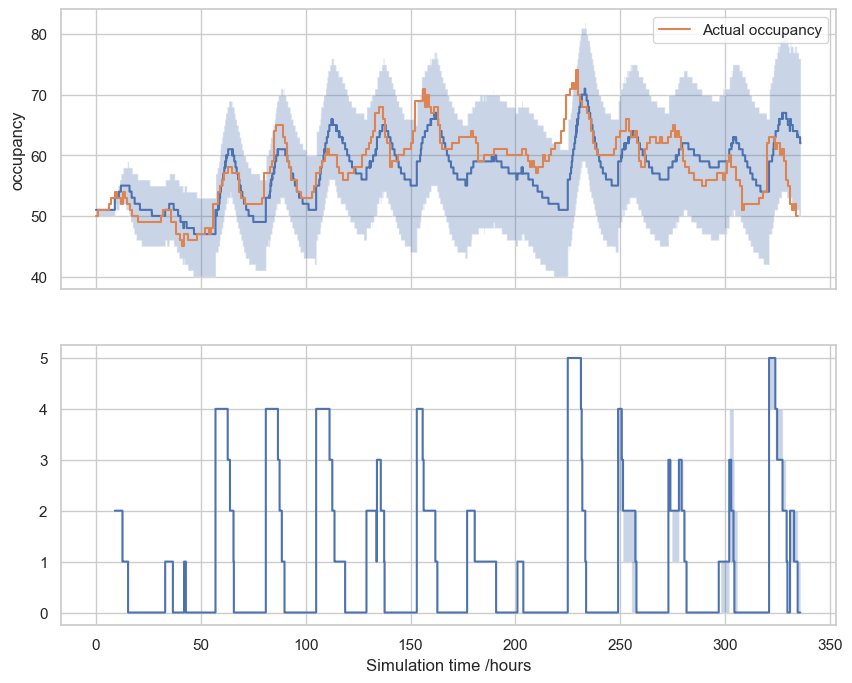

In [71]:
from functools import reduce

fig, ax = plt.subplots(2,1, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)


merged_beds_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), beds_ensemble).fillna(method='ffill').fillna(0)

sns.lineplot(x=merged_beds_df["Simulation time"], y=np.percentile(merged_beds_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[0], drawstyle='steps-post')
sns.lineplot(occupancy_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax[0])
ax[0].fill_between(
    merged_beds_df["Simulation time"], 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)


merged_surgery_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), surgeries_ensemble).fillna(method='ffill').fillna(0)
sns.lineplot(x=merged_surgery_df["Simulation time"], y=np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[1], drawstyle='steps-post')
ax[1].fill_between(
    merged_surgery_df["Simulation time"], 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)

plt.xlabel("Simulation time /hours")